In [1]:
from torchvision import datasets  # Contains the CIFAR-10 Dataset
from torchvision.transforms import ToTensor  # Tensor is used to encode the inputs and outputs
import numpy as np
import matplotlib.pyplot as plt     # Used to help visualize data
import random

# Downloading the CIFAR-10 Dataset

In [2]:
train_dataset = datasets.CIFAR10(root='data/', download=True, train=True, transform=ToTensor())
test_dataset = datasets.CIFAR10(root='data/', download=True, train=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


### Reshaping Dataset

In [3]:
X_train = train_dataset.data
y_train = np.array(train_dataset.targets)
X_test = test_dataset.data
y_test = np.array(test_dataset.targets)
print("Training Data Shape: ", X_train.shape)
print("Training Labels Shape: ", y_train.shape)
print("Test Data Shape: ", X_test.shape)
print("Test Labels Shape: ", y_test.shape)
X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float')
print("Reshaped Training Data: ", X_train.shape)
print("Reshaped Test Data: ", X_test.shape)

Training Data Shape:  (50000, 32, 32, 3)
Training Labels Shape:  (50000,)
Test Data Shape:  (10000, 32, 32, 3)
Test Labels Shape:  (10000,)
Reshaped Training Data:  (50000, 3072)
Reshaped Test Data:  (10000, 3072)


# kNN

In [4]:
def compute_distances(X_Train, X):
    # Distances formula from: https://medium.com/@souravdey/l2-distance-matrix-vectorization-trick-26aa3247ac6c
    distances = -2 * np.dot(X, X_Train.T) + np.sum(X_Train**2, axis=1) + np.sum(X**2, axis=1)[:, np.newaxis]
    return distances


def knn_predict(y_train, dists, k=3):
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
        closest_y = []
        nearest_neighbor_ids = np.argsort(dists[i])
        closest_y = list(y_train[nearest_neighbor_ids[:k]])
        pass
        y_pred[i] = (np.argmax(np.bincount(closest_y)))
        pass
    return y_pred


def knn_accuracy(y_prediction, y_test, num_test):
    correct = np.sum(y_prediction == y_test)
    accuracy = (float(correct) / num_test) * 100
    return accuracy    

### Performing kNN Cross-Validation

In [5]:
num_test = X_test.shape[0]
folds = 5
k_list = [3, 5, 7, 11]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, folds)
y_train_folds = np.array_split(y_train, folds)
k_accuracy = {}

for k in k_list:
    k_accuracy[k] = []
    for k_num in range(0, folds):
        X_test = X_train_folds[k_num]
        y_test = y_train_folds[k_num]
        X_train = X_train_folds
        y_train = y_train_folds

        tmp = np.delete(X_train, k_num, axis=0)
        X_train = np.concatenate((tmp), axis=0)
        y_train = np.delete(y_train, k_num, axis=0)
        y_train = np.concatenate((y_train), axis=0)

        distances = compute_distances(X_train, X_test)
        prediction = knn_predict(y_train, distances, k)
        
        accuracy = knn_accuracy(prediction, y_test, num_test)
        k_accuracy[k].append(accuracy)

print("5-Fold Accuracies for k: \n")
avgs = {}
for k in sorted(k_accuracy):
    row_avg = np.mean(k_accuracy[k])
    avgs[k] = (row_avg)
    for acc in k_accuracy[k]:
        print("k = %d, Accuracy = %f" % (k, acc))

5-Fold Accuracies for k: 

k = 3, Accuracy = 32.600000
k = 3, Accuracy = 32.610000
k = 3, Accuracy = 32.800000
k = 3, Accuracy = 32.520000
k = 3, Accuracy = 31.780000
k = 5, Accuracy = 33.500000
k = 5, Accuracy = 32.970000
k = 5, Accuracy = 33.360000
k = 5, Accuracy = 33.400000
k = 5, Accuracy = 32.830000
k = 7, Accuracy = 34.000000
k = 7, Accuracy = 33.300000
k = 7, Accuracy = 33.560000
k = 7, Accuracy = 33.100000
k = 7, Accuracy = 32.370000
k = 11, Accuracy = 33.810000
k = 11, Accuracy = 32.430000
k = 11, Accuracy = 33.070000
k = 11, Accuracy = 33.070000
k = 11, Accuracy = 32.320000


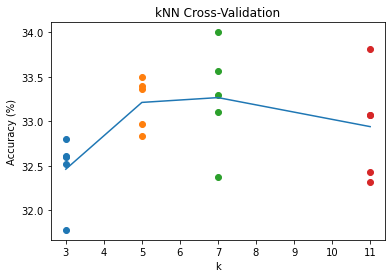

In [6]:
for k in k_list:
    accs = k_accuracy[k]
    plt.scatter([k] * len(accs), accs)

accs_mean = np.array([np.mean(v) for k,v in sorted(k_accuracy.items())])
plt.plot(k_list, accs_mean)
plt.title('kNN Cross-Validation')
plt.xlabel('k')
plt.ylabel('Accuracy (%)')
plt.show()

### Best k from Average of Accuracies 

In [7]:
best_k = max(avgs, key = avgs.get)
all_avgs = avgs.values()
max_avg = max(all_avgs)
print("Best k = %d, Average Accuracy = %f" % (best_k, max_avg))

Best k = 7, Average Accuracy = 33.266000


# k-Means

In [4]:
def init_centroids(X, k):
    centroids = X[random.sample(range(X.shape[0]), k)]
    return centroids


def compute_centroid_dist(X, centroid):
    dist = ((X - centroid) ** 2).sum(axis=X.ndim - 1)
    return dist


def closet_centroid(X, centroids):
    dist = compute_centroid_dist(X, centroids)
    return np.argmin(dist, axis=1)


def kmeans_fit(X_train, X, centroids, k=3):
    np.random.shuffle(X_train)      # Shuffles Data
    np.random.seed(0)               # Set for reproducibility
 
    a_centroids = np.zeros(len(X_train), dtype=np.int32)

    for n in range(25):
        a_centroids = closet_centroid(X_train[:, None, :], centroids[None, :, :])
        for c in range(k):
            cluster = X_train[a_centroids == c]
            cluster = cluster.mean(axis=0)

            centroids[c] = cluster

    kmeans_y_pred = closet_centroid(X[:, None, :], centroids[None, :, :])
    return kmeans_y_pred


def kmeans_accuracy(y_pred, y_test, num_test):
    correct = np.sum(y_pred == y_test)
    accuracy = (float(correct) / num_test) * 100
    return accuracy

### Performing k-Means Cross-Validation

In [5]:
num_test = X_test.shape[0]
km_folds = 5
km_list = [3, 5, 7, 11]

X_train_km_folds = []
y_train_km_folds = []

X_train_km_folds = np.array_split(X_train, km_folds)
y_train_km_folds = np.array_split(y_train, km_folds)
km_accuracy = {}

for k in km_list:
    centroids = init_centroids(X_train, k)
    km_accuracy[k] = []
    for k_num in range(0, km_folds):
        X_test = X_train_km_folds[k_num]
        y_test = y_train_km_folds[k_num]
        X_train = X_train_km_folds
        y_train = y_train_km_folds

        tmp = np.delete(X_train, k_num, axis=0)
        X_train = np.concatenate((tmp), axis=0)
        y_train = np.delete(y_train, k_num, axis=0)
        y_train = np.concatenate((y_train), axis=0)
        
        prediction = kmeans_fit(X_train, X_test, centroids, k)

        accuracy = kmeans_accuracy(prediction, y_test, num_test)
        km_accuracy[k].append(accuracy)

print("5-Fold Accuracies for k: \n")
km_avgs = {}
for k in sorted(km_accuracy):
    km_avg = np.mean(km_accuracy[k])
    km_avgs[k] = (km_avg)
    for acc in km_accuracy[k]:
        print("k = %d, accuracy = %f" % (k, acc))

5-Fold Accuracies for k: 

k = 3, accuracy = 10.340000
k = 3, accuracy = 10.670000
k = 3, accuracy = 10.140000
k = 3, accuracy = 10.320000
k = 3, accuracy = 10.080000
k = 5, accuracy = 8.160000
k = 5, accuracy = 8.360000
k = 5, accuracy = 8.720000
k = 5, accuracy = 8.730000
k = 5, accuracy = 8.300000
k = 7, accuracy = 10.250000
k = 7, accuracy = 10.910000
k = 7, accuracy = 10.320000
k = 7, accuracy = 10.950000
k = 7, accuracy = 9.790000
k = 11, accuracy = 7.310000
k = 11, accuracy = 7.930000
k = 11, accuracy = 8.160000
k = 11, accuracy = 8.310000
k = 11, accuracy = 8.630000


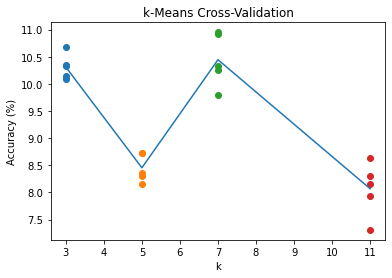

In [6]:
for k in km_list:
    acxs = km_accuracy[k]
    plt.scatter([k] * len(acxs), acxs)

acxs_mean = np.array([np.mean(v) for k,v in sorted(km_accuracy.items())])
plt.plot(km_list, acxs_mean)
plt.title('k-Means Cross-Validation')
plt.xlabel('k')
plt.ylabel('Accuracy (%)')
plt.show()

In [7]:
best_km = max(km_avgs, key = km_avgs.get)
best_km_avgs = km_avgs.values()
max_km_avg = max(best_km_avgs)
print("Best k = %d, Average Accuracy = %f" % (best_km, max_km_avg))

Best k = 7, Average Accuracy = 10.444000


# Softmax

### Normalize the Data and Add Bias Demension While Transforming into Columns

In [4]:
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image

# Add bias dimension and transform into columns
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

### Softmax Functions

In [5]:
def softmax_loss(W, X, y, regression):
    f = np.dot(W, X)
    f -= np.max(f, axis=0)
    P = np.exp(f) / np.sum(np.exp(f), axis=0)       # Softmax
    L = -1 / len(y) * np.sum(np.log(P[y, range(len(y))]))   # Cross-Entropy Loss
    R = 0.5 * np.sum(np.multiply(W, W))

    loss = L + R * regression       # Total loss

    P[y, range(len(y))] -= 1
    dW = 1 / len(y) * P.dot(X.T) + regression * W

    return loss, dW


def softmax_predict(W, X):
    y = W.dot(X)
    y_pred = np.argmax(y, axis=0)
    return y_pred


def softmax_accuracy(y_pred, y_test, num_test):
    correct = np.sum(y_test == y_pred)
    accuracy = (float(correct) / num_test) * 100
    print("Correct: %d/%d\nAccuracy: %f" % (correct, num_test, accuracy))

### Gradient Descent

In [6]:
def softmax_fit(W, X, y, lr=1e-5, regression=1e-3):
    _, N = X.shape
    loss_history = []
    for i in range(1000):
        idx = np.random.choice(N, 256, replace=True)
        X_batch = X[:, idx]
        y_batch = y[idx]

        loss, grad = softmax_loss(W, X_batch, y_batch, regression)
        loss_history.append(loss)

        W -= lr * grad

    return loss_history

### Performing Softmax

In [7]:
W = np.random.randn(10, 3073) * 0.0001
loss, grad = softmax_loss(W, X_train, y_train, 1e-5)

loss_record = softmax_fit(W, X_train, y_train, lr=1e-6, regression=1e-4)

y_test_pred = softmax_predict(W, X_test)

num_test = X_test.shape[1]
softmax_accuracy(y_test_pred, y_test, num_test)

Correct: 4063/10000
Accuracy: 40.630000


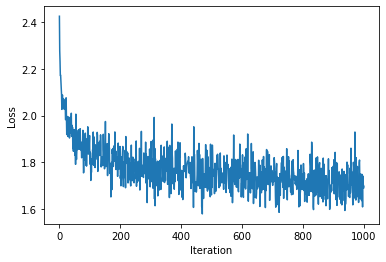

In [8]:
plt.plot(loss_record)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()